## Analysis and Prediction Model of Fuel Consumption and Carbon Dioxide Emissions of Light-Duty Vehicles

In this notebook we will reproduce the results obtained via the methodology described in the paper "Analysis and Prediction Model of Fuel Consumption and Carbon Dioxide Emissions of Light-Duty Vehicles" by Hien NLH, Kor A-L. 

### Summary of Techniques used

Data from the Open Government of Canada is collected on light duty vehicles, cleaned and combined into one spreadsheet (vehicles between 2017-2021). Descriptive statistics (mean, median, mode) and dispersion statistics (std, variance, range) are computed. Inferential statistics: t-test, ANOVA, correlation, Chi-Square. 

### Machine learning techniques used

#### Single variable
1. Time series regression, persistence models (walk forward validation), autoregression models (stats models), optimized autoregression (walk-forward over time steps). 
2. Linear Regression: using the sklearn model and the dataset is split into training and testing sets with 80%:20% ratio;
3. Univariate Polynomial Regression: using the sklearn model and 5 different degrees (from Degree 1 to Degree 5).

#### Multiple variables
1. Multiple Linear Regression: using the sklearn model and the dataset is split into training and testing sets with 80%:20% ratio;
2. Logarithmic Regression: using the sklearn model with log transformed predictor values and exponential transformed predictor values;
3. Exponential Regression: the dataset is split into training and testing sets with 75%:25% ratio;
4. Transformation of data: the dataset is split into training and testing sets with 75%:25% ratio;
5. Multivariate Polynomial Regression: using the sklearn model and 5 different degrees (from Degree 1 to Degree 5).
    
 
#### Deep learning
Convolutional Neural Network (CNN) is used in this study to predict a variable from multiple variables. Since CNN is normally used for image classification, to use CNN for regression problems, this research uses a one-dimensional convolutional network by reshaping input data.

#### Target variable

Total fuel consumption and CO2 emissions.

#### Function

ML as a function of data of engine size, number of cylinders, fuel consumption in a city and on a highway. Moreover, total fuel consumption and CO2 emission data were used to predict each other.

#### Evaluation of predictive accuracy: 

Efficiency and error statistics analysis using Nash-Sutcliffe efficiency coefficient. Bias, Mean Absolute Error (MAE), Root Mean Squared Error (RMSE). 

### Reference

Hien NLH, Kor A-L. Analysis and Prediction Model of Fuel Consumption and Carbon Dioxide Emissions of Light-Duty Vehicles. Applied Sciences. 2022; 12(2):803. https://doi.org/10.3390/app12020803 


In [1]:
import sys, os
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
sys.path.append(os.path.abspath(os.path.join('..','./data/', './clean-data/')))
paths = sys.path
clean_path = [item for item in paths if "machine-learning-capstone\\data\\clean-data" in item]
clean_data = clean_path[0]

file_name_2022_1995 = "1995_2022_vehicle_fuel_consumption.csv"

master_df = pd.read_csv(Path(clean_data,f'{file_name_2022_1995}'))
master_df['number_of_gears'].fillna(0, inplace=True)
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26159 entries, 0 to 26158
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   model_year                     26159 non-null  int64  
 1   make_                          26159 non-null  object 
 2   model.1_                       26159 non-null  object 
 3   vehicleclass_                  26159 non-null  object 
 4   enginesize_(l)                 26159 non-null  float64
 5   cylinders_                     26159 non-null  float64
 6   transmission_                  26159 non-null  object 
 7   fuel_type                      26159 non-null  object 
 8   fuelconsumption_city(l/100km)  26159 non-null  float64
 9   fuelconsumption_hwy(l/100km)   26159 non-null  float64
 10  fuelconsumption_comb(l/100km)  26159 non-null  float64
 11  fuelconsumption_comb(mpg)      26159 non-null  int64  
 12  co2emissions_(g/km)            26159 non-null 

In [3]:
# Subset data for vehicles between 2017 and 2021

subset_of_data = master_df[(master_df["model_year"]>=2017) & (master_df['model_year']<=2021)]

subset_of_data.head()

,model_year,make_,model.1_,vehicleclass_,enginesize_(l),cylinders_,transmission_,fuel_type,fuelconsumption_city(l/100km),fuelconsumption_hwy(l/100km),fuelconsumption_comb(l/100km),fuelconsumption_comb(mpg),co2emissions_(g/km),co2_rating,smog_rating,transmission_type,number_of_gears,mapped_fuel_type,type_of_wheel_drive
955,2021,acura,ilx,compact,2.4,4.0,AM8,Z,9.9,7.0,8.6,33,199,6.0,3.0,automated manual,8.0,premium gasoline,unspecified
956,2021,acura,nsx,two-seater,3.5,6.0,AM9,Z,11.1,10.8,11.0,26,256,4.0,3.0,automated manual,9.0,premium gasoline,unspecified
957,2021,acura,rdx sh-awd,suv - small,2.0,4.0,AS10,Z,11.0,8.6,9.9,29,232,5.0,6.0,automatic with select Shift,10.0,premium gasoline,All-wheel drive
958,2021,acura,rdx sh-awd a-spec,suv - small,2.0,4.0,AS10,Z,11.3,9.1,10.3,27,242,5.0,6.0,automatic with select Shift,10.0,premium gasoline,All-wheel drive
959,2021,acura,tlx sh-awd,compact,2.0,4.0,AS10,Z,11.2,8.0,9.8,29,230,5.0,7.0,automatic with select Shift,10.0,premium gasoline,All-wheel drive


In [4]:
# compute "Total fuel consumption (l/100 km) as the average of fuelconsumption_city(l/100km)	fuelconsumption_hwy(l/100km)	
subset_copy = subset_of_data.copy()
subset_copy['fuelconsumption_total(l/100km)'] = (subset_copy['fuelconsumption_city(l/100km)'] + subset_copy['fuelconsumption_hwy(l/100km)'])/2

## Descriptive statistics (mean, median, mode) and dispersion statistics (std, variance, range) are computed

In [5]:
subset_copy.describe()

,model_year,enginesize_(l),cylinders_,fuelconsumption_city(l/100km),fuelconsumption_hwy(l/100km),fuelconsumption_comb(l/100km),fuelconsumption_comb(mpg),co2emissions_(g/km),co2_rating,smog_rating,number_of_gears,fuelconsumption_total(l/100km)
count,5106.000000,5106.000000,5106.000000,5106.000000,5106.000000,5106.000000,5106.000000,5106.000000,5106.000000,5106.000000,5106.000000,5106.000000
mean,2018.931649,3.139561,5.627497,12.425343,9.088602,10.922777,27.560713,252.859185,4.566197,4.623188,7.022131,10.756972
std,1.401213,1.354059,1.895585,3.384607,2.111673,2.773325,7.352223,59.656089,1.664995,1.807754,1.945612,2.707586
min,2017.000000,0.900000,3.000000,4.000000,3.900000,4.000000,11.000000,94.000000,1.000000,1.000000,0.000000,3.950000
25%,2018.000000,2.000000,4.000000,10.100000,7.600000,9.000000,22.000000,211.000000,3.000000,3.000000,6.000000,8.900000
50%,2019.000000,3.000000,6.000000,12.000000,8.800000,10.600000,27.000000,248.000000,5.000000,5.000000,7.000000,10.400000
75%,2020.000000,3.700000,6.000000,14.400000,10.300000,12.600000,31.000000,291.000000,5.000000,6.000000,8.000000,12.350000
max,2021.000000,8.400000,16.000000,30.300000,20.900000,26.100000,71.000000,608.000000,10.000000,8.000000,10.000000,25.600000


#### Average data of different vehicle brands

In [6]:
subset_copy.groupby("make_").mean()

,model_year,enginesize_(l),cylinders_,fuelconsumption_city(l/100km),fuelconsumption_hwy(l/100km),fuelconsumption_comb(l/100km),fuelconsumption_comb(mpg),co2emissions_(g/km),co2_rating,smog_rating,number_of_gears,fuelconsumption_total(l/100km)
make_,,,,,,,,,,,,
acura,2018.960784,2.968627,5.254902,10.837255,8.513725,9.798039,29.137255,229.490196,5.000000,4.392157,8.549020,9.675490
alfa romeo,2019.060606,2.203030,4.545455,11.178788,8.154545,9.784848,29.424242,229.969697,5.000000,3.090909,7.575758,9.666667
aston martin,2019.115385,4.984615,10.461538,15.896154,10.915385,13.634615,21.076923,320.500000,2.961538,3.576923,7.884615,13.405769
audi,2019.058511,2.775532,5.537234,12.162234,8.679255,10.595213,27.345745,247.670213,4.590426,4.670213,7.335106,10.420745
bentley,2019.000000,5.393939,9.939394,18.727273,11.521212,15.481818,18.606061,361.666667,2.000000,3.303030,8.000000,15.124242
bmw,2018.933718,3.188473,6.138329,12.808069,9.055331,11.122478,26.172911,260.587896,4.291066,4.498559,7.610951,10.931700
bugatti,2019.833333,8.000000,16.000000,27.450000,17.550000,22.983333,12.500000,538.833333,1.000000,1.000000,7.000000,22.500000
buick,2018.854839,2.322581,4.548387,10.970968,8.212903,9.720968,29.483871,228.161290,5.064516,5.322581,7.129032,9.591935
cadillac,2018.971429,3.183810,5.409524,12.624762,8.824762,10.906667,26.361905,256.257143,4.295238,5.161905,8.485714,10.724762


#### Exploratory data analysis

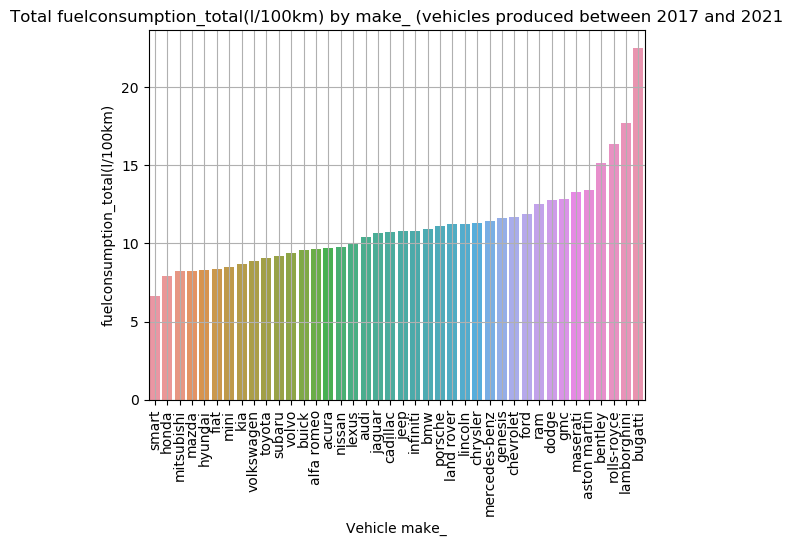

In [7]:
def generate_total_bar_chart_by_trait(df, trait, feature):
    sorted_fuel_cons = df.groupby(trait).mean()[feature].reset_index().sort_values(by=feature)
    sns.barplot(data=sorted_fuel_cons, x=trait, y=feature)
    plt.xticks(rotation=90)
    plt.title(f"Total {feature} by {trait} (vehicles produced between 2017 and 2021")
    plt.ylabel(f"{feature}")
    plt.xlabel(f"Vehicle {trait}")
    plt.grid(True)
    plt.show()
    
generate_total_bar_chart_by_trait(subset_copy, "make_", 'fuelconsumption_total(l/100km)')

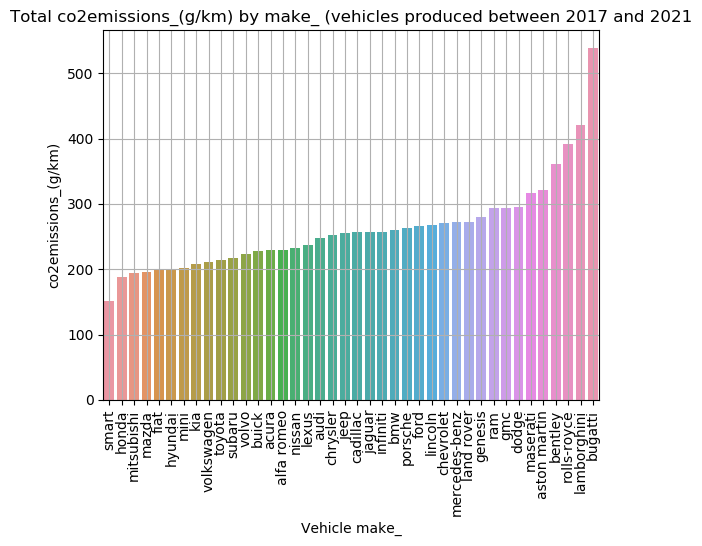

In [8]:
generate_total_bar_chart_by_trait(subset_copy, "make_", 'co2emissions_(g/km)')

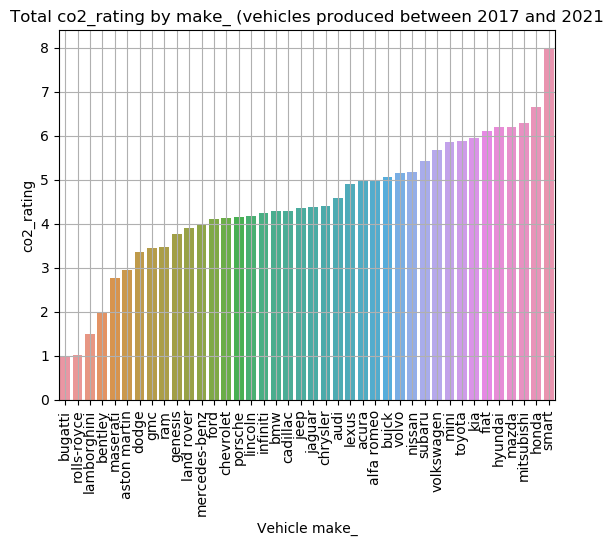

In [9]:
generate_total_bar_chart_by_trait(subset_copy, "make_", 'co2_rating')

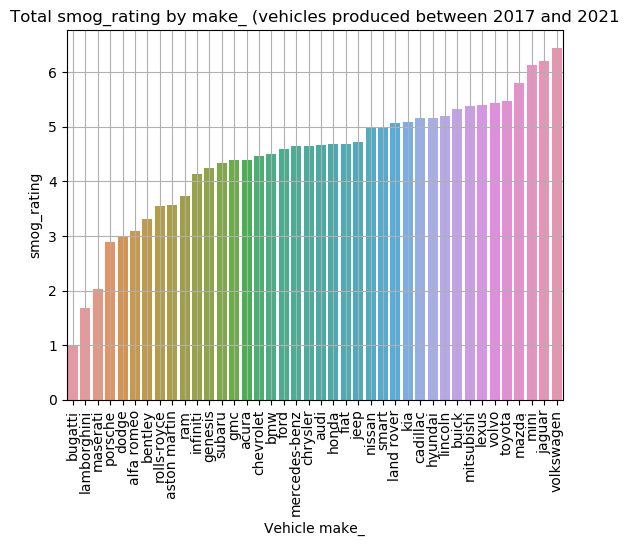

In [10]:
generate_total_bar_chart_by_trait(subset_copy, "make_", 'smog_rating')

#### Computing total fuel consumption by model

In [11]:
feature = ['fuelconsumption_total(l/100km)','co2emissions_(g/km)']
trait= "vehicleclass_"
sorted_fuel_model = subset_copy.groupby(trait).mean()[feature].reset_index().sort_values(by=feature, ascending=False)
sorted_fuel_model.head(10)

,vehicleclass_,fuelconsumption_total(l/100km),co2emissions_(g/km)
14,van - passenger,16.736842,362.631579
6,pickup truck - standard,13.337841,301.742138
12,suv - standard,13.096791,304.331551
13,two-seater,12.272414,292.269592
5,pickup truck - small,11.507328,281.801724
4,minivan,11.093617,257.978723
1,full-size,10.995632,257.655172
8,station wagon - mid-size,10.670455,254.409091
7,special purpose vehicle,10.655833,236.900000
10,subcompact,10.447742,248.851613


In [12]:
feature = ['fuelconsumption_total(l/100km)','co2emissions_(g/km)']
trait = 'cylinders_'
sorted_fuel_cyl = subset_copy.groupby(trait).mean()[feature].reset_index().sort_values(by=feature, ascending=False)
sorted_fuel_cyl.head(10)

,cylinders_,fuelconsumption_total(l/100km),co2emissions_(g/km)
7,16.0,22.500000,538.833333
6,12.0,16.454701,393.487179
5,10.0,14.831818,353.696970
4,8.0,13.772205,318.865854
3,6.0,11.329020,266.149107
2,5.0,10.192857,242.428571
1,4.0,8.757197,207.594847
0,3.0,7.680000,181.635294


In [13]:
feature = ['fuelconsumption_total(l/100km)','co2emissions_(g/km)']
trait = 'enginesize_(l)'
sorted_fuel_engs = subset_copy.groupby(trait).mean()[feature].reset_index().sort_values(by=feature, ascending=False)
sorted_fuel_engs.head(10)

,enginesize_(l),fuelconsumption_total(l/100km),co2emissions_(g/km)
44,8.0,22.500000,538.833333
40,6.5,20.575000,490.000000
43,6.8,18.160000,434.400000
45,8.4,16.250000,387.000000
41,6.6,16.205172,387.068966
42,6.7,16.184211,387.736842
37,6.0,15.630000,374.666667
32,5.2,14.555435,347.543478
34,5.5,14.486667,343.666667
33,5.3,14.348927,314.725322


In [14]:
feature = ['fuelconsumption_total(l/100km)','co2emissions_(g/km)']
trait = 'transmission_'
sorted_fuel_trans = subset_copy.groupby(trait).mean()[feature].reset_index().sort_values(by=feature, ascending=False)
sorted_fuel_trans.head(10)

,transmission_,fuelconsumption_total(l/100km),co2emissions_(g/km)
4,A7,13.063750,310.850000
12,AS5,12.981818,305.636364
3,A6,12.955914,289.021505
0,A10,12.811667,311.522222
2,A5,12.720370,295.370370
11,AS10,12.234413,280.408907
5,A8,12.188384,287.474747
14,AS7,11.897685,282.101852
8,AM7,11.284533,268.192000
25,M7,11.238889,267.222222


In [15]:
feature = ['fuelconsumption_total(l/100km)','co2emissions_(g/km)']
trait = 'mapped_fuel_type'
sorted_fuel_fuelt = subset_copy.groupby(trait).mean()[feature].reset_index().sort_values(by=feature, ascending=False)
sorted_fuel_fuelt.head(10)


,mapped_fuel_type,fuelconsumption_total(l/100km),co2emissions_(g/km)
1,ethanol (E85),16.355263,275.631579
2,premium gasoline,11.329008,269.662249
3,regular gasoline,9.905627,235.549818
0,diesel,9.177350,250.410256


In [16]:
subset_copy.groupby('model_year').mean().T

model_year,2017,2018,2019,2020,2021
enginesize_(l),3.107089,3.112188,3.107008,3.161674,3.221360
cylinders_,5.542533,5.596491,5.595644,5.688017,5.732200
fuelconsumption_city(l/100km),12.414650,12.361865,12.374148,12.458368,12.533900
fuelconsumption_hwy(l/100km),8.975331,8.991782,9.033239,9.151136,9.325186
fuelconsumption_comb(l/100km),10.865879,10.845983,10.868087,10.969835,11.088098
fuelconsumption_comb(mpg),27.688091,27.654663,27.651515,27.465909,27.304995
co2emissions_(g/km),249.924386,250.037858,251.279356,254.801653,259.180659
co2_rating,4.835539,4.572484,4.555871,4.487603,4.348565
smog_rating,6.034026,3.782087,4.144886,4.450413,4.719447
number_of_gears,6.502836,6.867959,7.029356,7.250000,7.540914


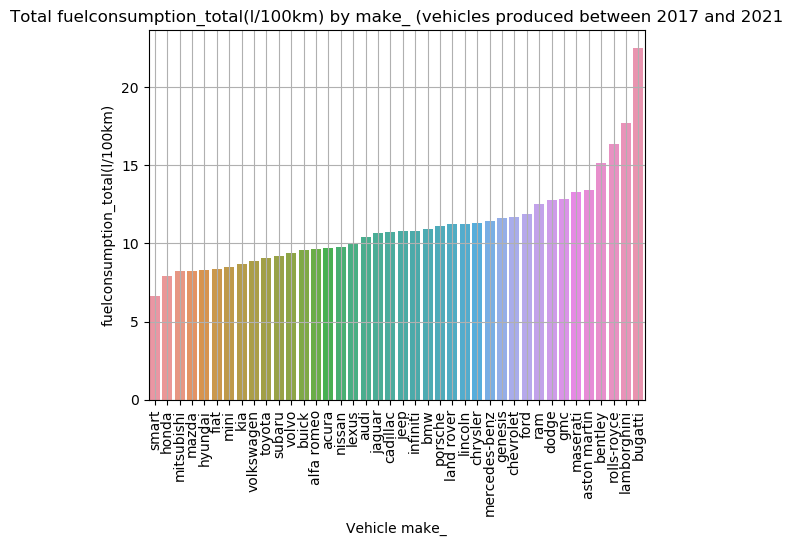

In [27]:
generate_total_bar_chart_by_trait(subset_copy, "make_", 'fuelconsumption_total(l/100km)')

In [74]:

subset_copy['model_year'] = subset_copy['model_year'].astype('str')

def plot_fuel_co2_emissions_overtime_by_make(df, make):
    make_data = df[df['make_']==make].sort_values(by='model_year')

    
    fig, ax =plt.subplots(1,2, figsize=(10,5))
    sns.scatterplot(data=make_data, x='model_year', y='fuelconsumption_total(l/100km)', style='model.1_', hue='model.1_',ax=ax[0])
    ax[0].set_title(f"Total fuel consumption for {make.capitalize()}")
    ax[0].set_ylim(0, make_data['fuelconsumption_total(l/100km)'].max()+1)
    ax[0].grid()
    ax[0].legend(bbox_to_anchor=(0.25, -0.12), loc='upper left', borderaxespad=0)

    sns.scatterplot(data=make_data, x='model_year', y='co2emissions_(g/km)', style='model.1_', hue='model.1_',ax=ax[1])
    ax[1].set_title(f"CO2 emissions for  {make.capitalize()}")
    ax[1].set_ylim(0, make_data['co2emissions_(g/km)'].max()+50)
    ax[1].grid()
    ax[1].legend(bbox_to_anchor=(0.25, -0.12), loc='upper left', borderaxespad=0)
    plt.show()

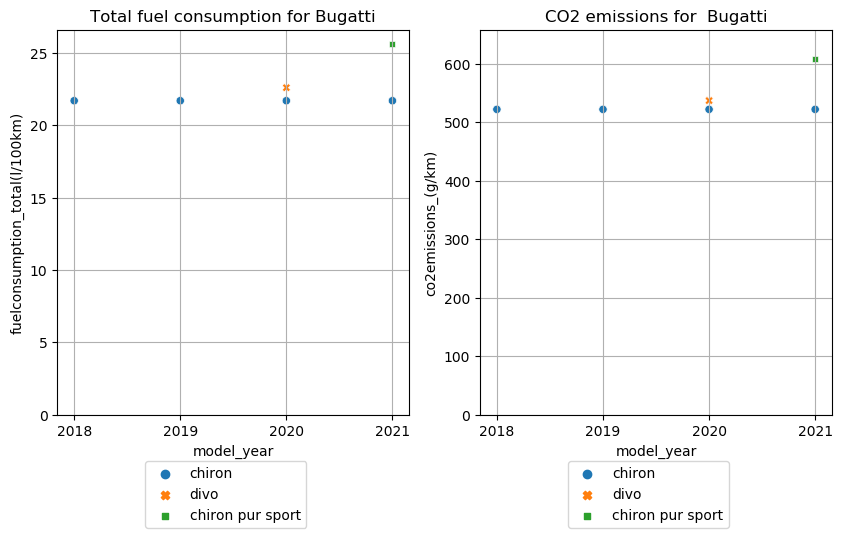

In [75]:
plot_fuel_co2_emissions_overtime_by_make(subset_copy, 'bugatti')

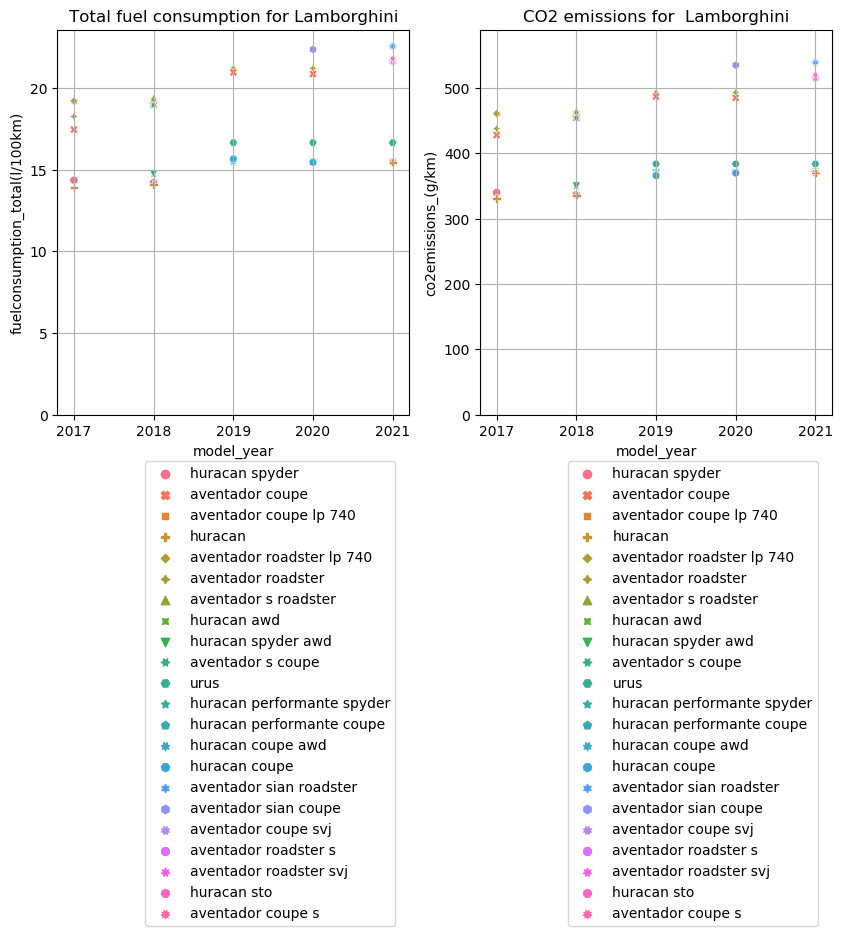

In [76]:
plot_fuel_co2_emissions_overtime_by_make(subset_copy, 'lamborghini')

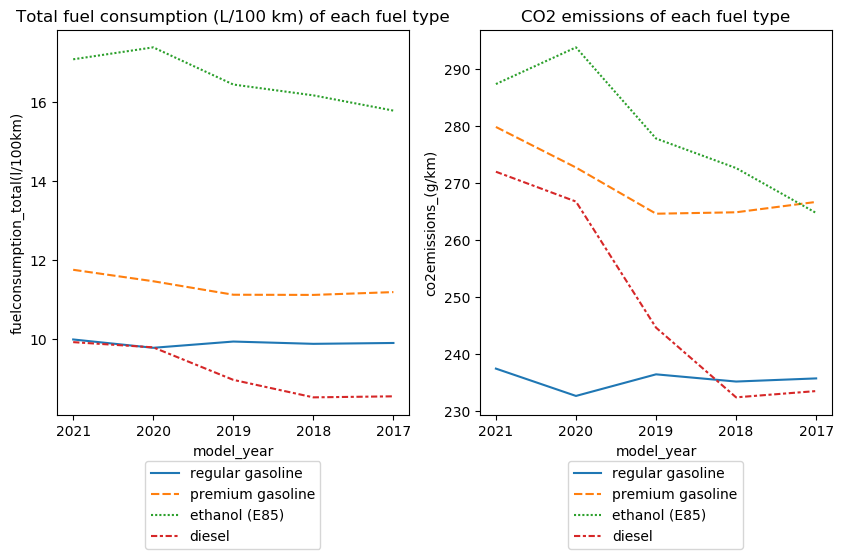

In [103]:
data_by_year_fuel = subset_copy.groupby(['model_year','mapped_fuel_type']).mean()[['fuelconsumption_total(l/100km)','co2emissions_(g/km)']].reset_index().sort_values(by='model_year', ascending=False)
fig, ax =plt.subplots(1,2, figsize=(10,5))
sns.lineplot(data=data_by_year_fuel, x='model_year', y='fuelconsumption_total(l/100km)', hue='mapped_fuel_type', style='mapped_fuel_type', ax=ax[0])
ax[0].set_title("Total fuel consumption (L/100 km) of each fuel type")
ax[0].legend(bbox_to_anchor=(0.25, -0.12), loc='upper left', borderaxespad=0)

sns.lineplot(data=data_by_year_fuel, x='model_year', y='co2emissions_(g/km)', hue='mapped_fuel_type', style='mapped_fuel_type', ax=ax[1])
ax[1].set_title("CO2 emissions of each fuel type")
ax[1].legend(bbox_to_anchor=(0.25, -0.12), loc='upper left', borderaxespad=0)
plt.show()

## Inferential statistics: t-test, ANOVA, correlation, Chi-Square.

#### (Is there any particular distribution for fuel consumption in the city and the highway of vehicles in Canada?

#### $t$-Test

A two-tailed t-test has been conducted to compare the means of fuel consumption in the city and on the highway for the same vehicle, with the following configurations.
* Null Hypothesis (H0): mean of fuel consumption in the city = mean of fuel consumption on a highway;
* Alternative Hypothesis (Ha): mean of fuel consumption in a city ≠ mean of fuel consumption in highway;
* Chosen confidence level: 99%, which means α = 0.01.

In [132]:
import researchpy as rp
import scipy.stats as stats

In [135]:
groupbed_by_individual = subset_copy.groupby(['make_','model.1_']).mean()[['fuelconsumption_city(l/100km)', 'fuelconsumption_hwy(l/100km)']].reset_index()
x1, x2 = subset_copy['fuelconsumption_city(l/100km)'], subset_copy['fuelconsumption_hwy(l/100km)']

summary, results = rp.ttest(group1= subset_copy['fuelconsumption_city(l/100km)'], group1_name= "city",
         group2= subset_copy['fuelconsumption_hwy(l/100km)'], group2_name= "highway")

print(summary)

   Variable        N       Mean        SD        SE  95% Conf.   Interval
0      city   5106.0  12.425343  3.384607  0.047366  12.332485  12.518201
1   highway   5106.0   9.088602  2.111673  0.029552   9.030667   9.146536
2  combined  10212.0  10.756972  3.277242  0.032430  10.693402  10.820542


In [136]:
print(results)

               Independent t-test     results
0  Difference (city - highway) =       3.3367
1           Degrees of freedom =   10210.0000
2                            t =      59.7673
3        Two side test p value =       0.0000
4       Difference < 0 p value =       1.0000
5       Difference > 0 p value =       0.0000
6                    Cohen's d =       1.1829
7                    Hedge's g =       1.1828
8               Glass's delta1 =       0.9859
9             Point-Biserial r =       0.5091


#### Interpretation

$p-\text{value} = 0.0 < \dfrac{\alpha}{2}$

Therefore the null hypothesis can be rejected. 

The average fuel consumption of vehicles in the city, 12.425343, was statistically signigicantly higher than in the highway, 9.088602; t(10210)= 59.7673, p= 0.0.


#### ANOVA

Is there a notable difference in the performance of one specific fuel type (or vehicle type) in comparison to the rest of the vehicle types in Canada?), a one-way ANOVA one-tailed test was implemented to compare the means of each vehicle class in terms of total fuel consumption, using the following assumptions.
* The samples are not dependent;
* Each sample comes from a population that is normally distributed;
* The group population standard deviations are all equal (homoscedasticity).